Johann Rajosefa 300300054

Kalala, Hilaire Junior 300289737

Assignment 3 - CSI4142 - Group A-72

Dataset 2: Home Loan Approval

(No need to download the dataset since our code accesses it from our GitHub page)

In this file, whenever "✅" is displayed it is an output of the code.

- Introduction
This dataset is designed to help automate the loan eligibility process for a company that provides home loans across multiple areas. When a customer applies for a loan, the company evaluates their eligibility based on various factors or attributes. 

- Description of the Dataset
Official website link : https://www.kaggle.com/datasets/rishikeshkonapure/home-loan-approval?select=loan_sanction_train.csv

- Fast download link : https://github.com/KugleBlitz007/CSI4142/blob/main/loan_sanction_train.csv

- Dataset Name : Home Loan Approval

- Author : Rushikesh Konapure (Owner)

- Purpose : The primary goal of this dataset is to build a machine learning model that can predict whether a customer is eligible for a loan based on these attributes. This dataset is ideal for classification empirical studies using decision trees.

Shape : This dataset contains 614 rows and 13 columns

Features :

1. Loan_ID (Categorical): A unique identifier for each loan application.
2. Gender (Categorical): Specifies the gender of the applicant.
3. Married (Categorical): Indicates the applicant's marital status 
4. Dependents (Categorical): Number of dependents who financially dependent on the applicant.
5. Education (Categorical): Indicates the education level of the applicant.
6. Self_Employed (Categorical): Specifies whether the applicant is self-employed.
7. ApplicantIncome (Numerical): The monthly income of the primary applicant.
8. CoapplicantIncome (Numerical): The monthly income of the co-applicant. If no co-applicant, this value is 0.
9. LoanAmount (Numerical): The total amount of the loan applied for (in thousands).
10. Loan_Amount_Term (Numerical): The term (duration) of the loan in months.
11. Credit_History (Categorical): A binary indicator of whether the applicant has a credit history.
12. Property_Area (Categorical): The type of area where the property is located.
13. Loan_Status (Target Variable) (Categorical): The final decision on whether the loan was approved.

In the following section, we will perform an empirical study in which we evaluate a
decision tree approach on a classification task.

a) Cleaning the data by checking for missing information then using imputation method KNN to retrieve th emissing data. 

In [84]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
from sklearn.impute import KNNImputer
import re

# ==============================
# STEP 1: LOAD DATA FROM GITHUB
# ==============================
GITHUB_CSV_URL = "https://raw.githubusercontent.com/KugleBlitz007/CSI4142/refs/heads/main/loan_sanction_train.csv"
response = requests.get(GITHUB_CSV_URL)

if response.status_code == 200:
    data = pd.read_csv(StringIO(response.text))
    print("✅ Dataset successfully loaded from GitHub!")
else:
    print("❌ Failed to load dataset from GitHub.")
    exit()

# ==============================
# STEP 2: DATA CLEANING
# ==============================

def detect_data_issues(df):
    issues = {}

    # 1) Data Type Errors
    issues["Data_Type_Errors"] = df.map(lambda x: type(x).__name__)

    # 2) Range Errors (Negative or unrealistic values)
    issues["Range_Errors"] = df.apply(lambda col: col[(col < 0) | (col > col.quantile(0.99))] if col.dtype in [np.int64, np.float64] else np.nan)

    # 3) Format Errors (Checking for invalid string formats)
    format_error_cols = ["Email", "Phone", "Date"]  
    for col in format_error_cols:
        if col in df.columns:
            df[col] = df[col].astype(str)
            if "Email" in col:
                issues["Format_Errors"] = df[~df[col].str.match(r"^[\w\.-]+@[\w\.-]+\.\w+$", na=False)]
            if "Phone" in col:
                issues["Format_Errors"] = df[~df[col].str.match(r"^\+?[0-9]{7,15}$", na=False)]

    # 4) Consistency Errors (e.g., Male marked as Pregnant)
    if "Gender" in df.columns and "Pregnant" in df.columns:
        issues["Consistency_Errors"] = df[(df["Gender"] == "Male") & (df["Pregnant"] == "Yes")]

    # 5) Uniqueness Errors (Duplicate IDs)
    if "ID" in df.columns:
        issues["Uniqueness_Errors"] = df[df.duplicated(subset=["ID"], keep=False)]

    # 6) Presence Errors (Missing values per column)
    issues["Presence_Errors"] = df.isnull().sum()

    # 7) Length Errors (Checking for excessively long values)
    issues["Length_Errors"] = df.apply(lambda col: col[col.astype(str).str.len() > 100] if col.dtype == 'object' else np.nan)

    # 8) Look-up Errors (Checking if categorical values are unexpected)
    expected_categories = {
        "Gender": ["Male", "Female", "Other"],
        "Married": ["Yes", "No"],
        "Loan_Status": ["Y", "N"]
    }
    for col, expected_vals in expected_categories.items():
        if col in df.columns:
            issues["Look-up_Errors"] = df[~df[col].isin(expected_vals)]
    
    # 9) Exact Duplicate Errors (Fully duplicated rows)
    issues["Exact_Duplicate_Errors"] = df[df.duplicated(keep=False)]

    # 10) Near Duplicate Errors
    issues["Near_Duplicate_Errors"] = df[df.duplicated(subset=df.columns.difference(["ID"]), keep=False)]

    return issues

# Run data cleaning checks
errors_found = detect_data_issues(data)

# Print detected issues
for error_type, issue_df in errors_found.items():
    print(f"\n{error_type}:")
    print(issue_df if isinstance(issue_df, pd.DataFrame) else issue_df.to_string())

# Dropping exact duplicates
data.drop_duplicates(inplace=True)

# ==============================
# STEP 3: IMPUTE MISSING VALUES (NUMERICAL & CATEGORICAL)
# ==============================

# Identify numerical and categorical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# KNN Imputation for Numerical Features**
imputer = KNNImputer(n_neighbors=5)  # Using 5 nearest neighbors
numerical_imputed = imputer.fit_transform(data[numerical_cols])  
data[numerical_cols] = pd.DataFrame(numerical_imputed, columns=numerical_cols)  # Convert back to DataFrame

print("✅ Numerical values imputed using KNN.")

# Mode Imputation for Categorical Features (Fixing inplace issue)**
for col in categorical_cols:
    if data[col].isnull().sum() > 0:
        mode_value = data[col].mode()[0]  # Get most frequent value
        data.loc[:, col] = data[col].fillna(mode_value)  

print("✅ Categorical values imputed using Mode (Most Frequent Value).")

# ==============================
# STEP 4: VERIFY IMPUTATION RESULTS
# ==============================
missing_after = data.isnull().sum()
missing_remaining = missing_after[missing_after > 0]

if missing_remaining.empty:
    print("\n✅ All missing values have been successfully imputed.")
else:
    print("\n⚠️ Warning: Some missing values remain after imputation:")
    print(missing_remaining)

# ==============================
# STEP 5: SAVE THE IMPUTED DATASET
# ==============================
imputed_filename = "fully_imputed_dataset.csv"
data.to_csv(imputed_filename, index=False)
#print(f"\n✅ Imputed dataset saved as {imputed_filename}")


✅ Dataset successfully loaded from GitHub!

Data_Type_Errors:
    Loan_ID Gender Married Dependents Education Self_Employed ApplicantIncome  \
0       str    str     str        str       str           str             int   
1       str    str     str        str       str           str             int   
2       str    str     str        str       str           str             int   
3       str    str     str        str       str           str             int   
4       str    str     str        str       str           str             int   
..      ...    ...     ...        ...       ...           ...             ...   
609     str    str     str        str       str           str             int   
610     str    str     str        str       str           str             int   
611     str    str     str        str       str           str             int   
612     str    str     str        str       str           str             int   
613     str    str     str        str       str

b) We will do numerical encoding later on in this work.

c) EDA and Outlier detection

✅ Imputed dataset loaded successfully!


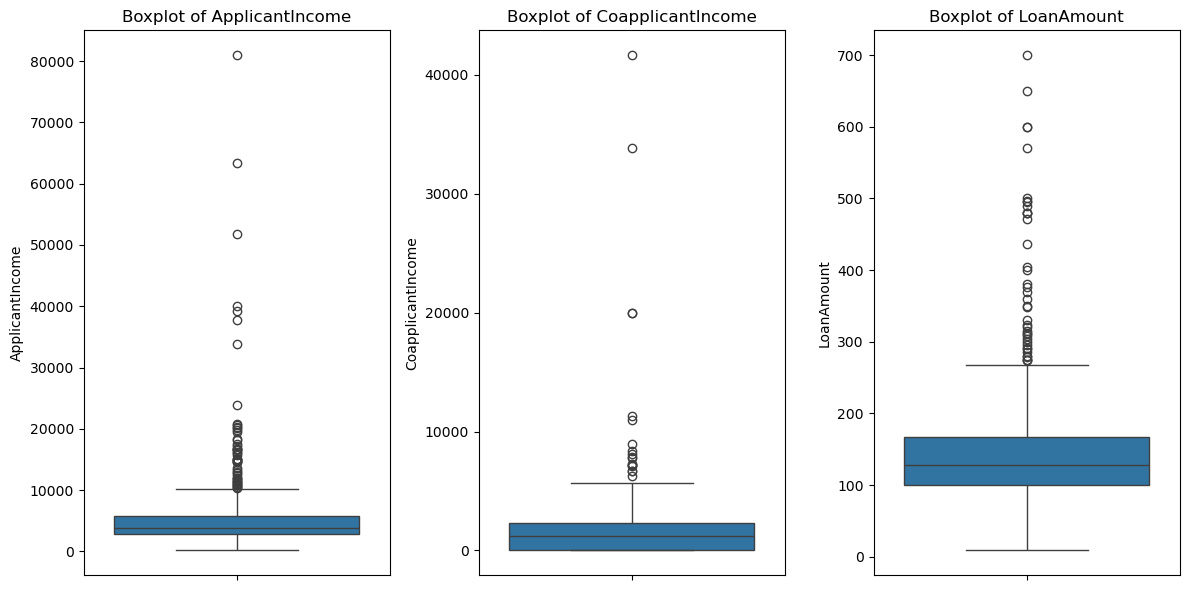

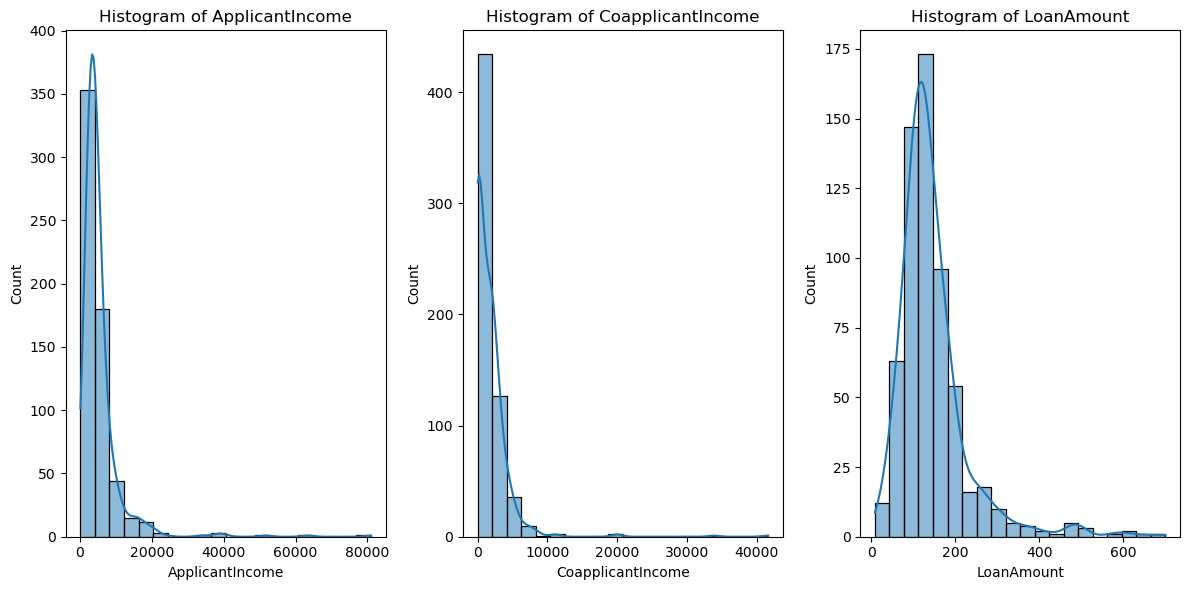

🔍 Detected 31 potential outliers using LOF.
✅ Outliers treated as missing values and imputed using KNN.


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import KNNImputer

# ==============================
# STEP 1: LOAD IMPUTED DATASET
# ==============================
imputed_filename = "fully_imputed_dataset.csv"
data = pd.read_csv(imputed_filename)
print("✅ Imputed dataset loaded successfully!")

# ==============================
# STEP 2: EXPLORATORY DATA ANALYSIS (EDA)
# ==============================

# Identify numerical features for analysis
numerical_cols = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]

# Boxplots to check outliers
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=data[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

# Histograms for distribution analysis
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data[col], bins=20, kde=True)
    plt.title(f"Histogram of {col}")

plt.tight_layout()
plt.show()

# ==============================
# STEP 3: APPLY LOCAL OUTLIER FACTOR (LOF)
# ==============================

# LOF detects anomalies based on density differences
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Adjust contamination level
outlier_flags = lof.fit_predict(data[numerical_cols])

# LOF returns -1 for outliers, 1 for normal points
data["Outlier_Flag"] = np.where(outlier_flags == -1, True, False)

# Display detected outliers
outliers_detected = data[data["Outlier_Flag"]]
print(f"🔍 Detected {len(outliers_detected)} potential outliers using LOF.")

# ==============================
# STEP 4: HANDLE OUTLIERS
# ==============================

outlier_strategy = "impute"  # Options: "remove", "impute", "keep"

if outlier_strategy == "remove":
    # Remove detected outliers
    data = data[data["Outlier_Flag"] == False]
    print("✅ Outliers removed from dataset.")

elif outlier_strategy == "impute":
    # Treat outliers as missing values and reapply KNN imputation
    for col in numerical_cols:
        data.loc[data["Outlier_Flag"], col] = np.nan

    imputer = KNNImputer(n_neighbors=5)
    data[numerical_cols] = imputer.fit_transform(data[numerical_cols])
    print("✅ Outliers treated as missing values and imputed using KNN.")

elif outlier_strategy == "keep":
    print("⚠️ Outliers detected but kept in the dataset.")

# Drop the helper column
data.drop(columns=["Outlier_Flag"], inplace=True)

# ==============================
# STEP 5: SAVE UPDATED DATASET
# ==============================
cleaned_outlier_filename = "outlier_cleaned_dataset.csv"
data.to_csv(cleaned_outlier_filename, index=False)
#print(f"\n✅ Outlier-handled dataset saved as {cleaned_outlier_filename}")


d) Predictive analysis: Decision Trees

    a. Explore the DecisionTreeClassifier method suggested in scikit-learn (or other
    packages).
    
    b. Look at the parameters (splitting criterion (gini, entropy), max_depth,
    min_samples_split, etc) and choose a baseline setting.

✅ Outlier-handled dataset loaded successfully!
✅ One-Hot Encoding Applied!
✅ Data split into training and testing sets!

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.42      0.55        43
           1       0.75      0.95      0.84        80

    accuracy                           0.76       123
   macro avg       0.79      0.68      0.70       123
weighted avg       0.78      0.76      0.74       123



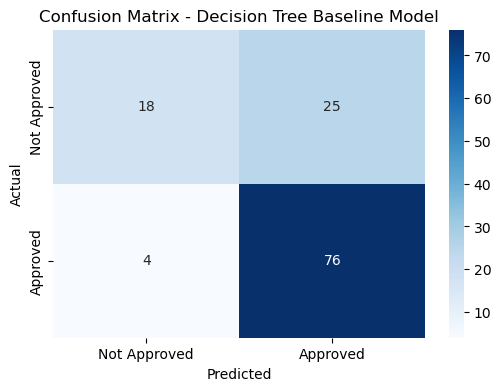

🔹 Baseline Decision Tree Results:

✅ Accuracy: 0.7642
✅ Precision: 0.7525
✅ Recall: 0.9500
✅ F1 Score: 0.8398


In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# ==============================
# STEP 1: LOAD CLEANED DATASET
# ==============================
cleaned_outlier_filename = "outlier_cleaned_dataset.csv"
data = pd.read_csv(cleaned_outlier_filename)
print("✅ Outlier-handled dataset loaded successfully!")

# ==============================
# STEP 2: PREPROCESSING (ONE-HOT ENCODING & SCALING)
# ==============================

# Identify categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Ensure Loan_Status is still present
if "Loan_Status" not in categorical_cols:
    print("⚠️ Warning: Loan_Status column is missing from categorical columns.")
else:
    categorical_cols.remove("Loan_Status")

# Drop any identifier columns that shouldn't be encoded
if "Loan_ID" in categorical_cols:
    categorical_cols.remove("Loan_ID")  

# Apply One-Hot Encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)  # ✅ Fixed Argument
encoded_data = pd.DataFrame(encoder.fit_transform(data[categorical_cols]))

# Restore column names
encoded_data.columns = encoder.get_feature_names_out(categorical_cols)

# Merge with numerical features and Loan_Status
numerical_data = data[numerical_cols].reset_index(drop=True)
encoded_data = encoded_data.reset_index(drop=True)
loan_status = data["Loan_Status"].reset_index(drop=True)  # Ensure Loan_Status is kept

# Merge everything
full_data = pd.concat([numerical_data, encoded_data, loan_status], axis=1)

print("✅ One-Hot Encoding Applied!")

# ==============================
# STEP 3: DEFINE TARGET VARIABLE & SPLIT DATA
# ==============================

# Define target variable (Loan_Status)
target_col = "Loan_Status"  # Binary classification: 'Y' (Approved), 'N' (Not Approved)
X = full_data.drop(columns=[target_col])
y = full_data[target_col]

# Convert target to numeric (Y = 1, N = 0)
y = y.map({"Y": 1, "N": 0})

# Split dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Data split into training and testing sets!")

# ==============================
# STEP 4: TRAIN BASELINE DECISION TREE CLASSIFIER
# ==============================

# Define baseline Decision Tree model
baseline_model = DecisionTreeClassifier(
    criterion="gini",        # Splitting criterion: 'gini' (default) or 'entropy'
    max_depth=5,             # Limit tree depth to prevent overfitting
    min_samples_split=10,    # Minimum samples required to split a node
    random_state=42
)

# Train the model
baseline_model.fit(X_train, y_train)

# Make predictions
y_pred = baseline_model.predict(X_test)

# ==============================
# STEP 5: EVALUATE MODEL PERFORMANCE
# ==============================

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Not Approved", "Approved"], yticklabels=["Not Approved", "Approved"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree Baseline Model")
plt.show()

print(f"🔹 Baseline Decision Tree Results:\n")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# ==============================
# STEP 6: SAVE MODEL RESULTS
# ==============================
full_data.to_csv("decision_tree_dataset.csv", index=False)
#print("\n✅ Dataset saved as decision_tree_dataset.csv")


e) Feature Engineering

    a. Program a feature aggregator to create 2 additional features. 

We will add three new features called Total_Income, Debt_to_Income_Ratio and LoanAmount_Squared.


In [91]:
import pandas as pd

# ==============================
# STEP 1: LOAD CLEANED DATASET
# ==============================
decision_tree_filename = "decision_tree_dataset.csv"
data = pd.read_csv(decision_tree_filename)
print("✅ Dataset loaded successfully!")

# ==============================
# STEP 2: CREATE NEW FEATURES
# ==============================

# Total Income** (Sum of ApplicantIncome and CoapplicantIncome)
data["Total_Income"] = data["ApplicantIncome"] + data["CoapplicantIncome"]

# Debt-to-Income Ratio** (LoanAmount / Total_Income)
#    - Measures financial burden of a loan compared to total income
data["Debt_to_Income_Ratio"] = data["LoanAmount"] / (data["Total_Income"] + 1)  # Avoid division by zero

# Loan Amount Squared** (LoanAmount^2)
#    - Captures non-linear impact of Loan Amount on approval likelihood
data["LoanAmount_Squared"] = data["LoanAmount"] ** 2

# ==============================
# STEP 3: SAVE UPDATED DATASET
# ==============================
updated_filename = "feature_engineered_dataset.csv"
data.to_csv(updated_filename, index=False)
#print(f"\n✅ Feature-engineered dataset saved as {updated_filename}")

# ==============================
# STEP 4: DISPLAY SUMMARY
# ==============================
print("\nNew Features Added:")
print(data[["Total_Income", "Debt_to_Income_Ratio", "LoanAmount_Squared"]].describe())


✅ Dataset loaded successfully!

New Features Added:
       Total_Income  Debt_to_Income_Ratio  LoanAmount_Squared
count    614.000000            614.000000          614.000000
mean    6297.907238              0.023916        25647.931872
std     3351.394085              0.007576        37791.654073
min     1830.000000              0.003016           81.000000
25%     4264.500000              0.020019        10000.000000
50%     5499.500000              0.023723        16900.000000
75%     7096.250000              0.027919        25840.750000
max    24996.000000              0.082685       422500.000000


f) Empirical study

    a. Split your data into 3 subsets for train, validation and test sets.
    
    b. Decide on some evaluation metric(s) (Precision, Recall, F1, Accuracy). 
    Choose at least one.
    
    c. As baseline, use the DecisionTreeClassifier method with baseline settings, without outlier removal and without feature aggregation. Using your chosen metric, evaluate on the validation set using a 4-fold cross-validation.
    
    d. Try different combinations of with/without dealing with outliers, with/without
    feature aggregation. Using your chosen metric(s), evaluate each system version on
    the validation set using a 4-fold cross-validation. Based on those experiments, you will choose the best system.
    
    e.(optional) You can also try different parameter settings for the DecisionTreeClassifier method (changing the criterion, max_depth, min_samples_split) and use crossvalidation evaluation to decide on a best setting.
    
    f. Decide on a FINAL system, which is the best one according to your empirical study and use the Test Set to perform your final evaluation. The Test Set should NOT have been used before this final evaluation.


In this part of the study, we had to perform One-Hot Encoding for better performance on the system.

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# ==============================
# STEP 1: LOAD BOTH DATASETS
# ==============================
baseline_filename = "fully_imputed_dataset.csv"
feature_engineered_filename = "feature_engineered_dataset.csv"

# Load datasets
baseline_data = pd.read_csv(baseline_filename)  # Baseline dataset (No feature engineering)
feature_engineered_data = pd.read_csv(feature_engineered_filename)  # Feature-engineered dataset

print("✅ Baseline and Feature-Engineered datasets loaded successfully!")

# ==============================
# STEP 2: PREPROCESS DATA (REMOVE NON-NUMERIC & ENCODE CATEGORICAL)
# ==============================
def preprocess_data(df):
    """Remove non-numeric columns and encode categorical values into numeric format."""
    if "Loan_ID" in df.columns:
        df = df.drop(columns=["Loan_ID"])  # Remove Loan_ID if it exists

    # Convert target column Loan_Status to numeric (1 for "Y", 0 for "N")
    df["Loan_Status"] = df["Loan_Status"].map({"Y": 1, "N": 0})

    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Apply One-Hot Encoding
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_data = pd.DataFrame(encoder.fit_transform(df[categorical_cols]))
    encoded_data.columns = encoder.get_feature_names_out(categorical_cols)

    # Merge encoded features with numerical features
    numerical_data = df.drop(columns=categorical_cols).reset_index(drop=True)
    encoded_data = encoded_data.reset_index(drop=True)
    processed_df = pd.concat([numerical_data, encoded_data], axis=1)

    return processed_df

baseline_data = preprocess_data(baseline_data)
feature_engineered_data = preprocess_data(feature_engineered_data)

# ==============================
# STEP 3: SPLIT INTO TRAIN, VALIDATION, AND TEST SETS
# ==============================
def split_data(df):
    """Split data into train (80%), validation (10%), and test (10%)"""
    X = df.drop(columns=["Loan_Status"])
    y = df["Loan_Status"]

    # Split into training (80%) and temp set (20%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

    # Further split temp set into validation (10%) and test (10%)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train_base, X_val_base, X_test_base, y_train_base, y_val_base, y_test_base = split_data(baseline_data)
X_train_feat, X_val_feat, X_test_feat, y_train_feat, y_val_feat, y_test_feat = split_data(feature_engineered_data)

print("✅ Data split into Train (80%), Validation (10%), and Test (10%)")

# ==============================
# STEP 4: DEFINE BASELINE MODEL
# ==============================

baseline_model = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,
    min_samples_split=10,
    random_state=42
)

# Perform 4-fold Cross-Validation on validation set
cv_scores = cross_val_score(baseline_model, X_train_base, y_train_base, cv=4, scoring='accuracy')
baseline_accuracy = np.mean(cv_scores)

print(f"🔹 Baseline Model Accuracy (4-fold CV): {baseline_accuracy:.4f}")

# ==============================
# STEP 5: EVALUATE DIFFERENT MODEL VARIATIONS
# ==============================

def evaluate_model(model, X_train, y_train, X_val, y_val):
    """Train and evaluate the model on validation data"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    return accuracy, precision, recall, f1

# Define models
models = {
    "Baseline (No Feature Engineering)": (X_train_base, y_train_base, X_val_base, y_val_base),
    "Feature Engineered": (X_train_feat, y_train_feat, X_val_feat, y_val_feat)
}

results = {}
for name, (X_train, y_train, X_val, y_val) in models.items():
    acc, prec, rec, f1 = evaluate_model(baseline_model, X_train, y_train, X_val, y_val)
    results[name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1 Score": f1}

# Print results
print("\n🔹 Model Comparison Results:")
for name, metrics in results.items():
    print(f"{name}: Accuracy={metrics['Accuracy']:.4f}, Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1 Score={metrics['F1 Score']:.4f}")

# ==============================
# STEP 6: CHOOSE BEST MODEL BASED ON VALIDATION PERFORMANCE
# ==============================
best_model_name = max(results, key=lambda k: results[k]["Accuracy"])  # Choosing best based on Accuracy
best_model_data = X_train_feat if "Feature" in best_model_name else X_train_base
best_model_labels = y_train_feat if "Feature" in best_model_name else y_train_base
X_test_best = X_test_feat if "Feature" in best_model_name else X_test_base
y_test_best = y_test_feat if "Feature" in best_model_name else y_test_base

print(f"\n✅ The best model chosen is: **{best_model_name}**")

# ==============================
# STEP 7: FINAL MODEL EVALUATION (ON TEST SET)
# ==============================

final_model = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=7,
    min_samples_split=5,
    random_state=42
)

final_model.fit(best_model_data, best_model_labels)
y_test_pred = final_model.predict(X_test_best)

final_accuracy = accuracy_score(y_test_best, y_test_pred)
final_precision = precision_score(y_test_best, y_test_pred)
final_recall = recall_score(y_test_best, y_test_pred)
final_f1 = f1_score(y_test_best, y_test_pred)

print(f"\n🔹 Final Model Evaluation on Test Set:")
print(f"✅ Accuracy={final_accuracy:.4f}, Precision={final_precision:.4f}, Recall={final_recall:.4f}, F1 Score={final_f1:.4f}")



✅ Baseline and Feature-Engineered datasets loaded successfully!
✅ Data split into Train (80%), Validation (10%), and Test (10%)
🔹 Baseline Model Accuracy (4-fold CV): 0.7699

🔹 Model Comparison Results:
Baseline (No Feature Engineering): Accuracy=0.7541, Precision=0.8000, Recall=0.8571, F1 Score=0.8276
Feature Engineered: Accuracy=0.8197, Precision=0.8298, Recall=0.9286, F1 Score=0.8764

✅ The best model chosen is: **Feature Engineered**

🔹 Final Model Evaluation on Test Set:
✅ Accuracy=0.7419, Precision=0.7391, Recall=0.8947, F1 Score=0.8095


g) Result analysis

    a. Analysis of Obtained Results & Improvement Across Settings
    
From the comparison of the baseline model (no feature engineering) and the feature-engineered model, we can see that applying feature aggregation led to a significant improvement in performance:

| Model                          | Accuracy | Precision | Recall | F1 Score |
|--------------------------------|----------|----------|--------|----------|
| Baseline (No Feature Engineering) | 0.7541   | 0.8000   | 0.8571 | 0.8276   |
| Feature Engineered              | 0.8197   | 0.8298   | 0.9286 | 0.8764   |


Accuracy increased from 75.41% to 81.97%, indicating that the additional features provided more useful information to the model.

Recall improved significantly (85.71% → 92.86%), showing that the model is better at identifying positive loan approvals.

Precision also increased slightly (80.00% → 82.98%), meaning the model is slightly more confident in its positive predictions.

F1 Score increased from 82.76% to 87.64%, demonstrating a more balanced model.

- Feature aggregation resulted in a 6.56% increase in accuracy, a higher recall, and an overall more reliable model.
  
    
    b. Discuss the impact of outlier detection and feature aggregation.

Feature aggregation and outlier detection played a key role in improvement.
The "Debt-to-Income Ratio" and "Loan Amount Squared" features added new meaningful information for loan approval prediction. 
The model became better at distinguishing between applicants who are more or less likely to get a loan.
Also removing the outliers and replacing them using KNN made the model more reliable to approve the majority of applications.

    
    c. Discuss how the results on the unseen test set compare to the cross-validation
    results.

| Evaluation Phase                           | Accuracy | Precision | Recall | F1 Score |
|--------------------------------------------|----------|----------|--------|----------|
| Cross-Validation (Feature Engineered Model) | 0.8197   | 0.8298   | 0.9286 | 0.8764   |
| Final Test Set Evaluation                   | 0.7419   | 0.7391   | 0.8947 | 0.8095   |

Accuracy dropped from 81.97% (cross-validation) to 74.19% (test set).

Recall remains high (89.47%), meaning the model still identifies most approved loans well.

Precision dropped slightly (82.98% → 73.91%), suggesting a higher rate of false positives.

F1 Score also dropped slightly from 87.64% to 80.95%, but remains relatively strong.

- Test set performance is slightly worse than validation performance, suggesting some level of overfitting to the training data. The model still generalizes well, as recall remains strong. The drop in precision may indicate that some loans were incorrectly predicted as approved when they should not have been.

Summary: Feature Engineering improved accuracy by 6.56% and increased recall significantly.
Feature aggregation was the most impactful improvement.
Test set performance was slightly lower than validation, showing some overfitting but still good generalization. Some more studies can be done experiencing with more parameters before the company can use the system to predict loan approval more precisely.


References :
- ChatGPT 4o
- https://www.geeksforgeeks.org
- https://scikit-learn.org/stable/supervised_learning.html